In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import shelve
import string
import numba as nb
import timeit
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import colors



In [ ]:
@nb.njit()
def frk4_step(y,u0,umid,u1,h,w,K,F,N):
    k1 = h * Fkuramoto_nb( y, u0,w,K,F,N)
    k2 = h * Fkuramoto_nb(y + 0.5 * k1, umid,w,K,F,N)
    k3 = h * Fkuramoto_nb( y + 0.5 * k2, umid,w,K,F,N)
    k4 = h * Fkuramoto_nb(y + k3, u1, w,K,F,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))

@nb.njit()
def whipeout(N, initlen, ut0,utmid,ut1, x0, h,w,p):
    uin, K,F= p[0],p[1], p[2]  
    for j in nb.prange(initlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
    return x

@nb.njit()
def kura_run(N,runlen, ut0, utmid,ut1, x0, h,w,p):
    uin, K,F = p[0],p[1], p[2]
    X = np.empty((N,runlen))
    for j in nb.prange(runlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
        X[:,j] = x
    return X

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut[i]-x[i])
    return y

@nb.njit()
def frk4closed_step(y,p,pvec,Wout,w,h,N):
    k1 = h * fkura_closed( y,p,pvec,Wout,w,N)
    k2 = h * fkura_closed(y + 0.5 * k1, p,pvec,Wout,w,N)
    k3 = h * fkura_closed( y + 0.5 * k2, p,pvec,Wout,w,N)
    k4 = h * fkura_closed(y + k3, p,pvec,Wout,w,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))
    
@nb.njit()
def fkura_closed(x,p,pvec,Wout,w,N):  
    uin, K,F = p[0],p[1],p[2]
    one_hot = pvec   
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0
    Up0= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))  
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(Up0[one_hot[i]]*uin-x[i]) 
    return y

def unroll_parameter(p_dict):
    N = p_dict['N']
    K = p_dict['K']
    uin = p_dict['uin']
    h = p_dict['h']
    mu = p_dict['mu']
    sigma = p_dict['sigma']
    w = p_dict['w']
    F = p_dict['F']
    reg = p_dict['reg']
    one_hot = p_dict['one_hot']
    testlen = p_dict['test']
    trainlen = p_dict['train']
    initlen = p_dict['init']
    data_scale = p_dict['data_scale']
    return N,K,uin,h,mu,sigma,w,F,reg,one_hot,testlen,trainlen,initlen,data_scale

@nb.njit()
def NMSE(yeval,ydata):
    
    nmse = np.zeros(yeval.shape[0], dtype='float64')
    for i in nb.prange(yeval.shape[0]):
        for j in nb.prange(yeval.shape[1]):
            nmse[i] += (ydata[i,j]-yeval[i,j])**2
        nmse[i]=nmse[i]/numba_norm(ydata[i,:])**2
    return nmse

@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)

@nb.njit()
def nb_concatdot30( x, y): 
    res = np.zeros(3,dtype = 'float64')
    for i in nb.prange(x.shape[1]):
        if i==0:
            res[0]+=x[0,i]
            res[1]+=x[1,i]
            res[2]+=x[2,i]
        else:
            res[0]+=x[0,i]*y[i-1]
            res[1]+=x[1,i]*y[i-1]
            res[2]+=x[2,i]*y[i-1]
    return res

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 


def training(data_scaled,p,pvec,w,h,N,initlen=2500,trainlen=10_000):
    ut0 =np.eye(3)[pvec] @ data_scaled[:,::20]
    utmid =np.eye(3)[pvec] @ data_scaled[:,10:][:,::20]
    ut1 =np.eye(3)[pvec] @  data_scaled[:,20:][:,::20]

    x=whipeout(N,initlen, ut0,utmid,ut1, np.linspace(0,2*math.pi,N), h, w,p)
    X0= kura_run(N,trainlen, ut0[:,initlen:],utmid[:,initlen:],ut1[:,initlen:], x,h,w,p)

    X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)


    Yt = data_scaled [:,::20][:,(initlen+1):(initlen+trainlen+1)].T

    Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T
    pred = (Wout @ X)
    nmse_train = NMSE(  np.dot(Wout,X), Yt.T).mean()

    u0 = Yt.T[:,-1] #(Wout @ X[:,-1]) # #
    x0= X0[:,-1] 

    return x0,Wout,nmse_train


def test_closed(x0,p,pvec,Wout,w,h,N,s_steps):
    Xtest=np.zeros((N,s_steps), dtype='float64')
    Upred=np.zeros((3,s_steps), dtype='float64')
    x=x0
    for i in nb.prange(s_steps):
        x = frk4closed_step(x,p,pvec,Wout,w,h,N)
        Xtest[:,i] = x
        Upred[:,i]= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))
    return Xtest, Upred




In [40]:

with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['lorenz'] 

In [41]:
with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['lorenz'] 

with shelve.open('shelve/param.shelve', 'r') as shelf:
    p_dict = shelf['lorenz']


N,K,uin,h,mu,sigma,w,F,reg,one_hot_output,testlen,trainlen,initlen, data_scale = unroll_parameter(p_dict)
data_scaled = data/data_scale
data_sampled= data_scaled [:,::20]

## Section 2

In [42]:
N,K,uin,h,mu,sigma,w,F,reg,one_hot_output,testlen,trainlen,initlen, data_scale = unroll_parameter(p_dict)
p = np.array([uin, K,F])
K,F= p[1],p[2]

testlen=10_000
x0,Wout,nmse_train = training(data_scaled,p,one_hot_output,w,h,N,initlen=initlen,trainlen=trainlen)
Xpred, Upred=test_closed(x0,p,one_hot_output,Wout,w,h,N,testlen)

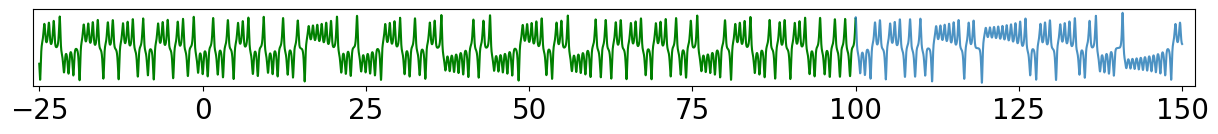

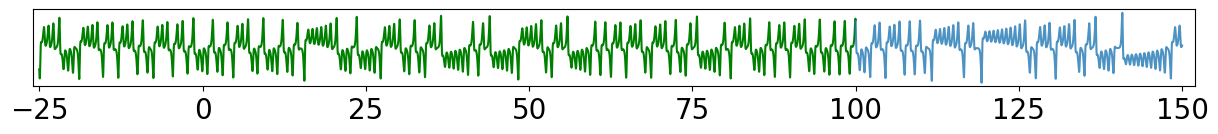

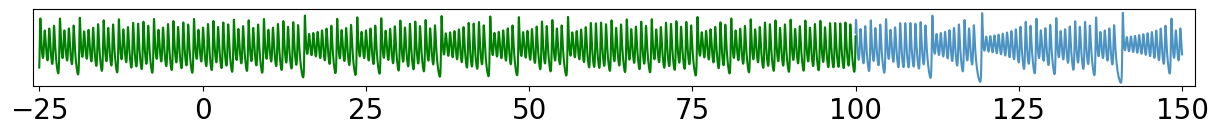

In [43]:
T=100+ np.arange(0,50,0.01)

fig = plt.figure(figsize=(15,1))
plt.plot(np.arange(-25,100,0.01),data_sampled[0,1:12_501],'g')
plt.plot(T,Upred[0,:len(T)],label='prediction',alpha=0.8)
plt.xticks(np.arange(-25,151,25),fontsize=20)
plt.xlim([-26,152])
plt.yticks([])
plt.savefig(f'Pictures_paper/datax.jpg',dpi=200,bbox_inches = 'tight')

fig = plt.figure(figsize=(15,1))
plt.plot(np.arange(-25,100,0.01),data_sampled[1,1:12_501],'g')
plt.plot(T,Upred[1,:len(T)],label='prediction',alpha=0.8)
plt.xticks(np.arange(-25,151,25),fontsize=20)
plt.xlim([-26,152])
plt.yticks([])
plt.savefig(f'Pictures_paper/datay.jpg',dpi=200,bbox_inches = 'tight')

fig = plt.figure(figsize=(15,1))
plt.plot(np.arange(-25,100,0.01),data_sampled[2,1:12_501],'g')
plt.plot(T,Upred[2,:len(T)],label='prediction',alpha=0.8)
plt.xticks(np.arange(-25,151,25),fontsize=20)
plt.xlim([-26,152])
plt.yticks([])
plt.savefig(f'Pictures_paper/dataz.jpg',dpi=200,bbox_inches = 'tight')


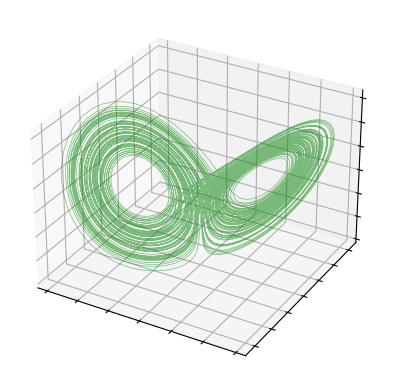

In [44]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*data_sampled[:,:10_000], 'g',lw=0.5,alpha=0.5)
# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_zlabel('$z$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
plt.savefig(f'Pictures_paper/data3d.jpg',dpi=200,bbox_inches = 'tight')

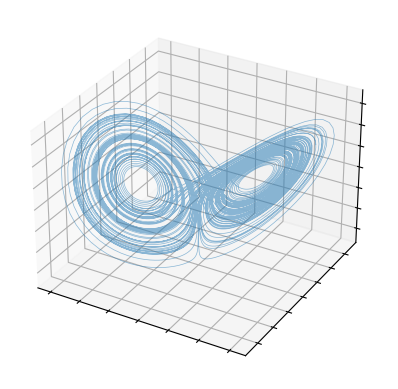

In [45]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*Upred[:,:10_000], lw=0.5,alpha=0.5)
# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_zlabel('$z$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
plt.savefig(f'Pictures_paper/pred3d.jpg',dpi=200,bbox_inches = 'tight')

## Section 4

Note on reproducing the figures below: quantitatively the figures below might change depending on the version of numba 
you are using (I am using 0.57.1). This is because we are dealing with extremely long time evolutions that depend sensitively
on initial conditions and because numba moves around the operations to make them efficient. Globally there does not seem to be any difference.

In [46]:
Klist = []
Rlist = []
Plist = []
X0list = []
Y0list = []
Clist = []
F=35
with shelve.open(f'shelve/Kbifu.shelve', 'r') as shelf:
    for K in shelf.keys():

        Plist.append(shelf[K][3])
        Klist.append(shelf[K][1])
        Rlist.append(shelf[K][2])
        X0list.append(shelf[K][4])
        Y0list.append(shelf[K][5])
        Clist.append(shelf[K][7])

m=1
Karray= np.array(Klist[::m]) 
Rarray= np.array(Rlist[::m]) 
Parray= np.array(Plist[::m]) 
Carray= np.array(Clist[::m])

In [47]:
Rmin  =  np.array([  min(np.sqrt(x0**2 + y0**2)[-10_000:])  for  x0,y0 in zip(X0list[::m],Y0list[::m])   ])
Rmax  =  np.array([  max(np.sqrt(x0**2 + y0**2)[-10_000:])  for  x0,y0 in zip(X0list[::m],Y0list[::m])   ])
X0_ct = np.array([  np.linalg.norm(x0[-10_001:-1]-x0[-10_000:],2)==0  for  x0 in X0list[::m]   ])
Y0_ct = np.array([  np.linalg.norm(y0[-10_001:-1]-y0[-10_000:],2)==0  for  y0 in Y0list[::m]   ])
Cb = np.array(Carray>0)

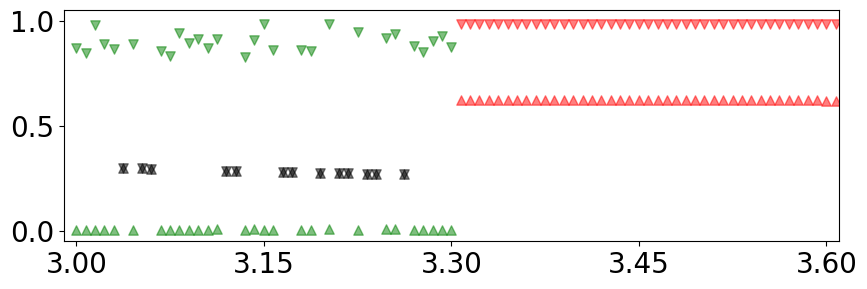

In [48]:
fig = plt.figure(figsize=(10,3))
frame1 = plt.gca()  
plt.scatter(Karray[Cb],Rmin[Cb], color='green',marker='^', s=45, alpha=0.5)
plt.scatter(Karray[Cb],Rmax[Cb], color='green',marker='v', s=45, alpha=0.5)
plt.scatter(Karray[(Y0_ct + X0_ct)],Rmin[(Y0_ct + X0_ct)], color='black',marker='^', s=45, alpha=0.5)
plt.scatter(Karray[(Y0_ct + X0_ct)],Rmax[(Y0_ct + X0_ct)],s=45, color='black',marker='v', alpha=0.5)
plt.scatter(Karray[ (Parray == False) & (Cb == False) & ((Y0_ct + X0_ct)==False)    ],\
            Rmin[ (Parray == False) & (Cb == False)  & ((Y0_ct + X0_ct)==False)    ], color='red',marker='^', s=45, alpha=0.5)
plt.scatter(Karray[ (Parray == False) & (Cb == False) & ((Y0_ct + X0_ct)==False)    ],\
            Rmax[ (Parray == False) & (Cb == False)  & ((Y0_ct + X0_ct)==False)    ], color='red',marker='v', s=45, alpha=0.5)
plt.xticks([3,3.15,3.3,3.45,3.6],fontsize=20)
plt.yticks([0,0.5,1],fontsize=20)
plt.xlim([2.99,3.61])
plt.ylim([-0.05,1.05])
plt.savefig(f'Pictures_paper/learning_bifu.jpg',dpi=200,bbox_inches = 'tight')


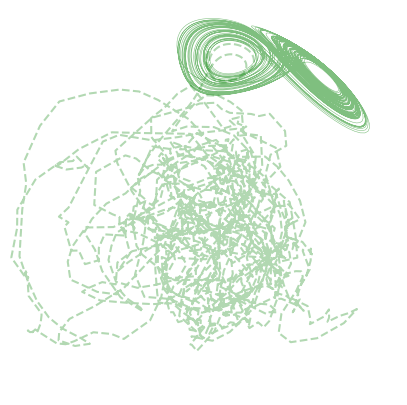

In [49]:
i = 0
fig = plt.figure(figsize=(5,5))
m1=7_800 
m2=9_000
plt.plot(X0list[i][:m1],Y0list[i][:m1],color='green',alpha=0.5, linewidth=0.4)
plt.plot(X0list[i][m1:m2],Y0list[i][m1:m2],'--',color='green',alpha=0.3)
plt.xlim([-0.75,0.95])
plt.ylim([-0.75,1])
plt.axis('off')
plt.savefig(f'Pictures_paper/incoher.jpg',dpi=1000,bbox_inches = 'tight')



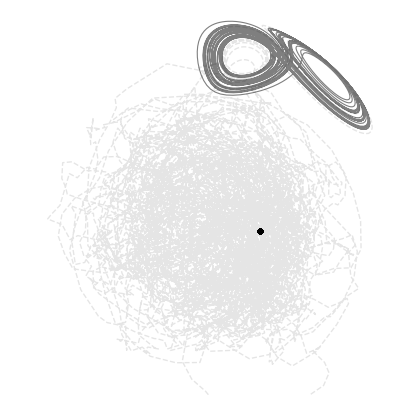

In [50]:
i= np.where(Y0_ct + X0_ct)[0][2]
fig = plt.figure(figsize=(5,5))
m1=4_000
m2=10_000
plt.plot(X0list[i][:m1],Y0list[i][:m1],color='black',alpha=0.5,linewidth=0.8)
plt.plot(X0list[i][m1:m2],Y0list[i][m1:m2],'--',color='black',alpha=0.1,linewidth=1)
plt.plot(X0list[i][-100_000:],Y0list[i][-100_000:],'.',color='black',alpha=0.5)
plt.xlim([-0.9,0.95])
plt.ylim([-0.75,1])
plt.axis('off')
plt.savefig(f'Pictures_paper/stat.jpg',dpi=200,bbox_inches = 'tight')

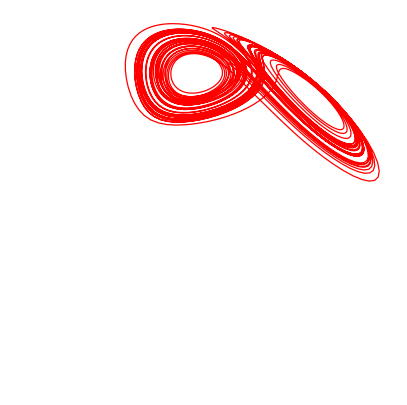

In [51]:
i= np.where((Parray == False) & (Cb == False) & ((Y0_ct + X0_ct)==False))[0][10]
fig = plt.figure(figsize=(5,5))
plt.plot(X0list[i][:5_000],Y0list[i][:5_000], color='red',linewidth=0.9)
plt.xlim([-0.4,0.9])
plt.ylim([-0.3,1])
plt.axis('off')
plt.savefig(f'Pictures_paper/rlor.jpg',dpi=200,bbox_inches = 'tight')

## Section 5

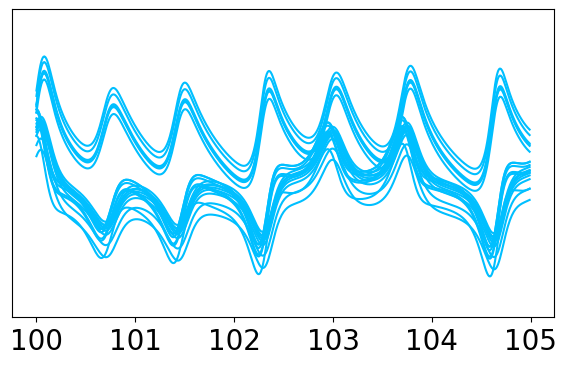

In [52]:
fig = plt.figure(figsize=(7,4))
plt.plot(np.arange(100,105,0.01), (Xpred.T[:500,:20]+3) % (2*np.pi),markersize=0.5, color='deepskyblue')
#plt.ylabel(r'$\theta$')
#plt.xlabel('t')
#plt.ylim([0,2*np.pi])
plt.ylim([2,5])
plt.yticks([])
plt.xticks(fontsize=20)
plt.savefig(f'Pictures_Paper/states.jpg',dpi=300,bbox_inches = 'tight')

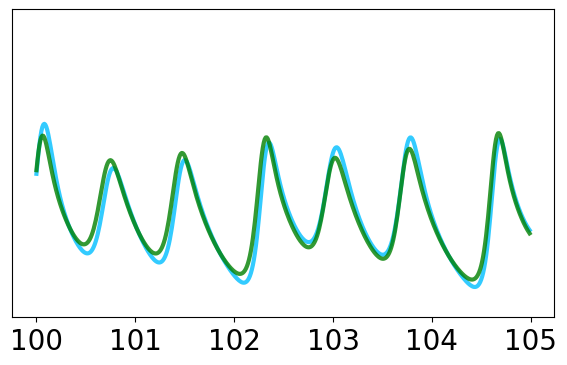

In [53]:
fig = plt.figure(figsize=(7,4))
T=np.arange(0,2000,0.01) 
plt.plot(T[:500]+100,((Xpred.T[:500,320]-0.4)% np.pi*2)/1.8+0.1,label=r' $C_1 \theta_i+ C_2$', color='deepskyblue',alpha=0.8,linewidth=3)
plt.plot(T[:500]+100,data_sampled[2, initlen+trainlen+1:initlen+trainlen+1+500],label='z',color='g',alpha=0.8,linewidth=3)
#plt.legend()
#plt.xlabel('t')
#plt.ylabel('$R/ 2 \pi Z$')
plt.ylim([0,2.3])
plt.xticks(fontsize=20)
plt.yticks([])
plt.savefig(f'Pictures_Paper/theta_iz.jpg',dpi=300,bbox_inches = 'tight')

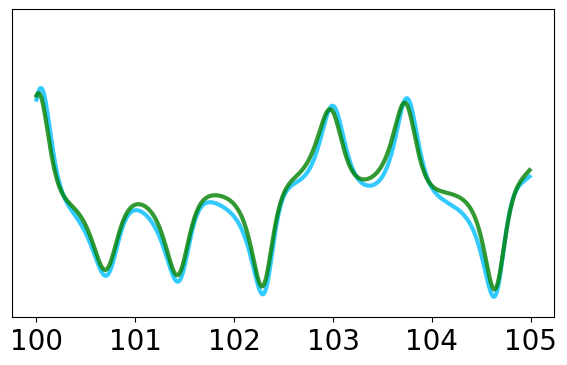

In [54]:
fig = plt.figure(figsize=(7,4))
plt.plot(  T[:500]+100, (((Xpred.T[:500,100]) +0.8 ) % np.pi*2)/2, label=r'$C_1 \theta_i + C_2$',alpha=0.8,linewidth=3, color='deepskyblue')
plt.plot(T[:500]+100,data_sampled[0, initlen+trainlen+1:initlen+trainlen+1+500]+1,label=' x + C ',color='g',alpha=0.8,linewidth=3)
plt.ylim([0.3,2])
plt.yticks([])
plt.xticks(fontsize=20)
#plt.legend(loc='upper left')
#plt.xlabel('t')
#plt.ylabel('$R/ 2 \pi Z$')
plt.savefig(f'Pictures_Paper/theta_ix.jpg',dpi=300,bbox_inches = 'tight')

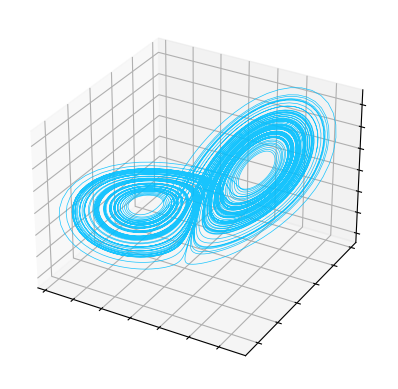

In [55]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot((Xpred[0,:] +1)% np.pi*2,(Xpred[2,:] +1)% np.pi*2,Xpred[4,:],  lw=0.5,alpha=0.9,color='deepskyblue')
# ax.set_xlabel(r'$\theta_1$')
# ax.set_ylabel(r'$\theta_3$')
# ax.set_zlabel(r'$\theta_5$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
plt.savefig(f'Pictures_Paper/theta_3d.jpg',dpi=300,bbox_inches = 'tight')

In [56]:
dzmax = []
ilist = []
zdata_samp=data_sampled[2,initlen:initlen+trainlen]
dz= zdata_samp[1:] - zdata_samp[:-1]
tlist = []
T=np.arange(0,100,0.01)
for i,t in zip(range(0,len(dz)-1),T[:-1]):
    if dz[i]>0 and dz[i+1]<0:
        dzmax.append(zdata_samp[i])
        ilist.append(i)
        tlist.append(t)
# plt.scatter(dzmax[:-1], dzmax[1:],s=1)
# plt.xlabel('max $ z_n$')
# plt.ylabel('max $z_{n+1}$')
# plt.grid()

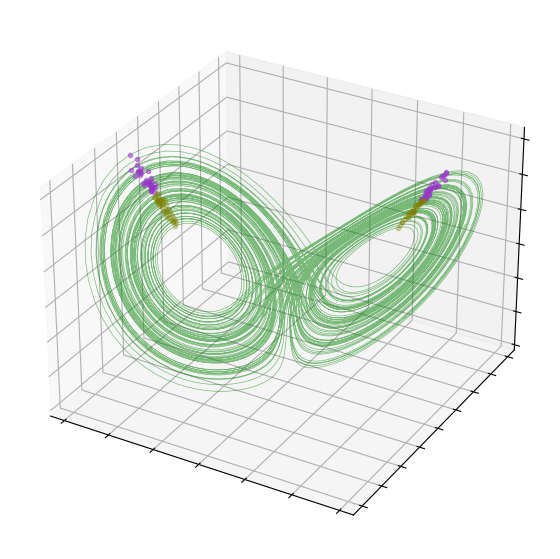

In [57]:

ilist = []
z1 = []
z2 =[]
t1 = []
t2 =[]
T=np.arange(0,100,0.01)

for i,t in zip(range(0,len(dz)-1),T[:-2]):
    if dz[i]>0 and dz[i+1]<0:
        if zdata_samp[i]<1.245:
            z1.append(i)
            t1.append(t)
        else:
            z2.append(i)
            t2.append(t)

z1=np.array(z1)
z2=np.array(z2)

ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.plot(*data_sampled[:,initlen:initlen+trainlen],color='green', lw=0.5,alpha=0.5, label= 'data')
ax.plot(*data_sampled[:,initlen:initlen+trainlen][:,z2],'.', color='darkorchid',lw=0.5,alpha=0.5, label='$I_1$')
ax.plot(*data_sampled[:,initlen:initlen+trainlen][:,z1],'.', color = 'olive',lw=0.5, alpha=0.3,label='$I_2$')

# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_zlabel('$z$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
plt.savefig(f'Pictures_paper/3dz.jpg',dpi=800,bbox_inches = 'tight')

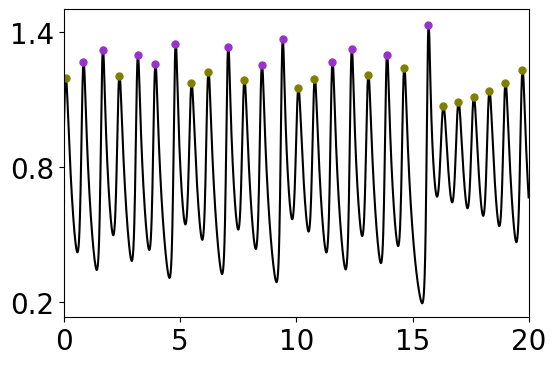

In [58]:
fig = plt.figure(figsize=(6,4))
plt.plot(T[:2000],zdata_samp[:2000],label='z',color='black')
#plt.ylabel('$z$')
plt.plot(t2,zdata_samp[z2],'.',color='darkorchid',markersize=10)
plt.plot(t1,zdata_samp[z1],'.', color='olive',markersize=10 )
plt.xlim([0,20])
plt.xticks(np.arange(0,21,5),fontsize=20)
plt.yticks([0.2,0.8,1.4],fontsize=20)
#plt.xlabel('t')
plt.savefig(f'Pictures_paper/zmaxi.jpg',dpi=800,bbox_inches = 'tight')

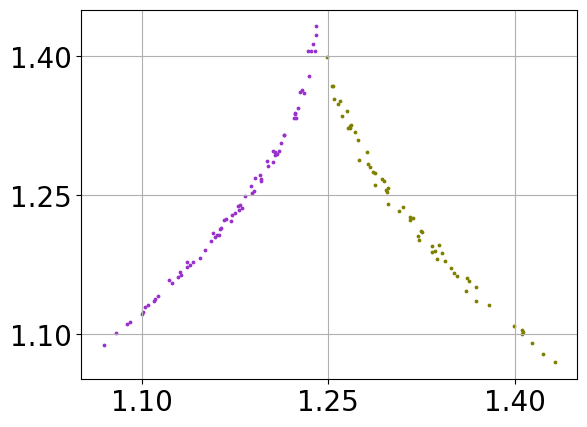

In [59]:
d1 = 1.245
d2 = 4
dzmax = np.array(dzmax)
plt.scatter(dzmax[:-1][dzmax[:-1]<d1], dzmax[1:][dzmax[:-1]<d1],s=3,label='$I_1$',color='darkorchid')
plt.scatter(dzmax[:-1][ (dzmax[:-1]>d1)*(dzmax[:-1]<d2) ], dzmax[1:][(dzmax[:-1]>d1)*(dzmax[:-1]<d2)],s=3,color='olive',label='$I_2$')
#plt.xlabel('max $z_n$')
#plt.ylabel('max $z_{n+1}$')
plt.xticks([1.1,1.25,1.4],fontsize=20)
plt.yticks([1.1,1.25,1.4],fontsize=20)

#plt.legend()
plt.grid()
plt.savefig(f'Pictures_paper/z1z2.jpg',dpi=800,bbox_inches = 'tight')
plt.show()

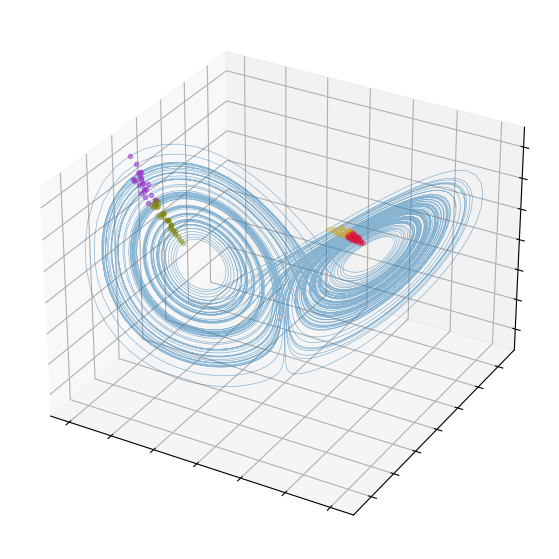

In [60]:
rtest= np.sqrt((np.cos(Xpred).sum(axis=0))**2+(np.sin(Xpred).sum(axis=0))**2)/N

T=np.arange(100,200,0.01)
drmin = []
ilist = []
r1 = []
r2 =[]
r3 = []
r4 = []
t1 = []
t2 =[]
t3 = []
t4 = []

dr= (rtest[1:] - rtest[:-1])
for i,t in zip(range(0,len(dr)-1),T):
    if dr[i]<0 and dr[i+1]>0 and abs(dr[i]-dr[i+1])>0.001/5:
        if rtest[i]<0.805:
            r1.append(i)
            t1.append(t)
        elif rtest[i]<0.875:
            r2.append(i)
            t2.append(t)
        elif rtest[i]<0.9281:
            r3.append(i)
            t3.append(t)
        else:
            r4.append(i)
            t4.append(t)

r1=np.array(r1)
r2=np.array(r2)
r3=np.array(r3)
r4=np.array(r4)

ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.plot(*Upred, lw=0.5,alpha=0.5, label= 'data')
ax.plot(*Upred[:,r1],'.', color='darkorchid',lw=0.5,alpha=0.5, label='$I_1$')
ax.plot(*Upred[:,r2],'.', color='olive',lw=0.5, alpha=0.3,label='$I_2$')
ax.plot(*Upred[:,r3],'.', lw=0.5,alpha=0.3, color='goldenrod', label='$I_3$')
ax.plot(*Upred[:,r4],'.', lw=0.5, alpha=0.3,color='crimson',label='$I_4$')


#ax.legend(loc='upper left')
#ax.set_xlabel('$x$')
#ax.set_ylabel('$y$')
#ax.set_zlabel('$z$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
#plt.savefig(f'Pictures_paper/r1r2r3r43D.jpg',dpi=800,bbox_inches = 'tight')

Text(0.5, 0, 't')

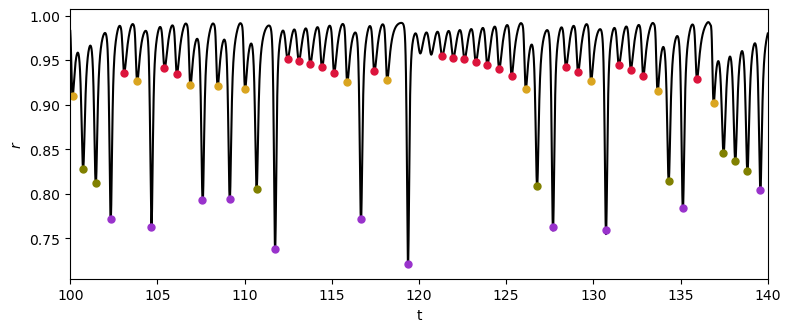

In [61]:
f = plt.figure() 
f.set_figwidth(9) 
f.set_figheight(3.5) 
plt.plot(T,rtest,label='r',color='black')
plt.ylabel('$r$')
plt.plot(t1,rtest[r1],'.',color='darkorchid',markersize=10)
plt.plot(t2,rtest[r2],'.',color='olive', markersize=10 )
plt.plot(t3,rtest[r3],'.',color='goldenrod',markersize=10)
plt.plot(t4,rtest[r4],'.',color='crimson',markersize=10)
plt.xlim([100,140])
#plt.plot(T[:2000],data_sampled[0,initlen:initlen+trainlen][:2000],label='x')
#plt.plot(T[:2000],data_sampled[1,initlen:initlen+trainlen][:2000],label='y')
#plt.plot(T[:2000],data_sampled[2,initlen:initlen+trainlen][:2000],label='z')
plt.xlabel('t')
#plt.legend()
#plt.savefig(f'Pictures_paper/onlyr.jpg',dpi=800,bbox_inches = 'tight')

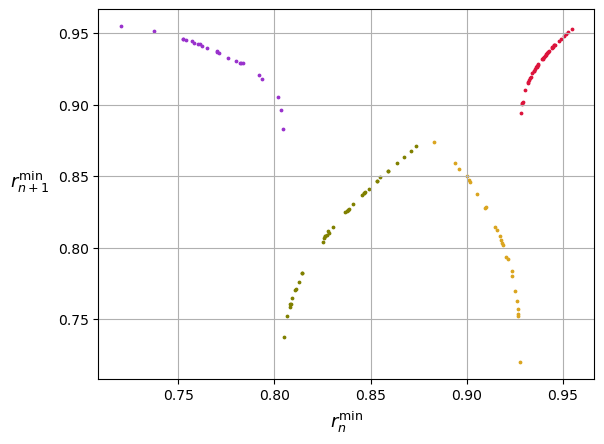

In [62]:
drmin = []
ilist = []

d1 = 0.805
d2 = 0.875
d3 = 0.9281
d4 = 1

dr= rtest[1:] - rtest[:-1]
for i in range(0,len(dr)-1):
    if dr[i]<0 and dr[i+1]>0 and abs(dr[i]-dr[i+1])>0.001/5:
        drmin.append((rtest[i]+rtest[i+1])/2)
        ilist.append(i)
drmin = np.array(drmin)
plt.scatter(drmin[:-1][drmin[:-1]<d1], drmin[1:][drmin[:-1]<d1],s=3,label='$I_1$',color='darkorchid')
plt.scatter(drmin[:-1][ (drmin[:-1]>d1)*(drmin[:-1]<d2) ], drmin[1:][(drmin[:-1]>d1)*(drmin[:-1]<d2)],color='olive',s=3,label='$I_2$')
plt.scatter(drmin[:-1][ (drmin[:-1]>d2)*(drmin[:-1]<d3) ], drmin[1:][(drmin[:-1]>d2)*(drmin[:-1]<d3)],color='goldenrod',s=3,label='$I_3$')
plt.scatter(drmin[:-1][ (drmin[:-1]>d3)*(drmin[:-1]<d4) ], drmin[1:][(drmin[:-1]>d3)*(drmin[:-1]<d4)],color='crimson',s=3,label='$I_4$')
plt.xlabel('$r_n^{\min}$',fontsize=13, rotation =0 )
plt.ylabel('$r_{n+1}^{\min}$', fontsize=13,rotation =0,labelpad=20)
#plt.legend()
plt.grid()
plt.savefig(f'Pictures_paper/r1r2r3r4.jpg',dpi=800,bbox_inches = 'tight')
plt.show()

## Section 6

In [63]:
Klist = []
Flist =[] 
windinglist = []
NMSE_testmean = []
with shelve.open('shelve/nmse_low.shelve', 'r') as shelf:
    for k in shelf.keys():
        if k != 'parameters':
            test_k = shelf[k][1]
            
            kdum = k.replace('K','').replace('F','').split('|')
            
            Klist.append(float(kdum[0]))
            Flist.append(float(kdum[1]))
            
            NMSE_testmean.append(test_k['NMSE_test_mean'])
            windinglist.append(test_k['winding'])

print(f'tot_parameters {len(Klist)}')

tot_parameters 400


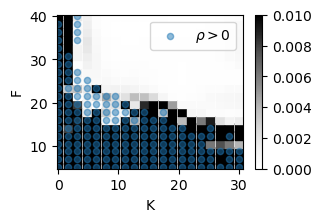

In [64]:
Karray_full= np.array(Klist)
Farray_full= np.array(Flist)
windingarray_full= np.array(windinglist).sum(axis=1)
fig = plt.figure(figsize=(3,2))
plt.scatter(Karray_full,Farray_full,c=NMSE_testmean,marker='s',s=35,cmap='Greys',vmin=0,vmax=0.01)
plt.colorbar()
plt.xlim([-0.2,30.7])
plt.ylim([4.7,40.3])
plt.xlabel('K')
plt.ylabel('F')
plt.scatter(Karray_full[windingarray_full>0],Farray_full[windingarray_full>0],marker='o',s=20, alpha=0.5,label=r"$\rho >0$")
plt.savefig(f'Pictures_paper/nmse_full.jpg',dpi=1000,bbox_inches = 'tight')
plt.legend()

In [65]:
Klist = []
Flist =[] 
trJlist = []
LElist = []
LElist_mean = []
LE_evo = []
windinglist = []
NMSE_testmean = []
conv_steps = []
with shelve.open('shelve/lya_low.shelve', 'r') as shelf:
    for k in shelf.keys():
        if k != 'parameters':
            test_k = shelf[k][1]
            
            kdum = k.replace('K','').replace('F','').split('|')
            
            Klist.append(float(kdum[0]))
            Flist.append(float(kdum[1]))
            
            NMSE_testmean.append(test_k['NMSE_test_mean'])
            
            LE= np.array(test_k['LE'])
            LE.sort()
            LElist.append(LE)
            trJlist.append(test_k['trJ']) 
            LEmean = np.array(test_k['LEi_sort'][-250:]).mean(axis=0)
            LElist_mean.append(LEmean)
            LE_evo.append(test_k['LEi_sort'])

            conv_steps.append(test_k['conv_steps'])
print(f'tot_parameters {len(Klist)}')
Karray= np.array(Klist)
Farray= np.array(Flist)

tot_parameters 200


In [66]:
l0 = np.array( [l[0] for l in LElist_mean])
l1 = np.array( [l[1] for l in LElist_mean])
l2 = np.array( [l[2] for l in LElist_mean])


In [67]:
t_scale=1

LE1=np.array(l0)/t_scale
LE2=np.array(l1)/t_scale
LE3=np.array(l2)/t_scale


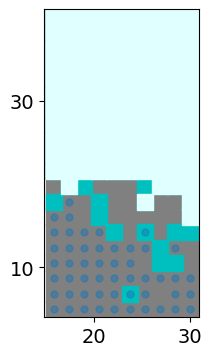

In [68]:
fig = plt.figure(figsize=(2,4))
er2=0.02 # at some level this is a bit arbitrary, see below
msize=117
lz_like01 =  ( np.abs(LE1-0.9056) <= er2) & (np.abs(LE2) <=0.01) & (LE3 <=-0.01)
lz_like_rest =  ( LE1 > 0.01) & (np.abs(LE2) <=0.01) & (LE3 <-0.01)
plt.scatter(Karray, Farray, marker='s', color ='grey', s=msize, label='no chaotic attractor')
plt.scatter(Karray[lz_like_rest],Farray[lz_like_rest],marker='s', color='c', s=msize,label='greater than 0.02')

plt.scatter(Karray[lz_like01],Farray[lz_like01],marker='s',s=msize, color='lightcyan', label='0.01')
# plt.xlabel('K',fontsize=14)
# plt.ylabel('F', rotation=0,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yticks(np.arange(10, 71, step=20)) 
plt.xlim([min(Karray)-1,max(Karray)+1])
plt.ylim([min(Farray)-1,max(Farray)+1])
plt.scatter(Karray_full[windingarray_full>0],Farray_full[windingarray_full>0],marker='o',s=25, alpha=0.5,label=r"$\rho >0$")
plt.savefig(f'Pictures_paper/new_bifu.jpg',dpi=300,bbox_inches = 'tight')

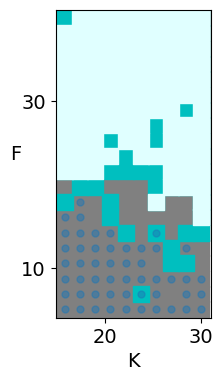

In [69]:
fig = plt.figure(figsize=(2,4))
er2=0.01 
msize=117
lz_like01 =  ( np.abs(LE1-0.9056) <= er2) & (np.abs(LE2) <=0.01) & (LE3 <=-0.01)
lz_like_rest =  ( LE1> 0.01) & (np.abs(LE2) <=0.01) & (LE3 <-0.01)
plt.scatter(Karray, Farray, marker='s', color ='grey', s=msize, label='no chaotic attractor')
plt.scatter(Karray[lz_like_rest],Farray[lz_like_rest],marker='s', color='c', s=msize,label='greater than 0.02')

plt.scatter(Karray[lz_like01],Farray[lz_like01],marker='s',s=msize, color='lightcyan', label='0.01')
plt.xlabel('K',fontsize=14)
plt.ylabel('F', rotation=0,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yticks(np.arange(10, 71, step=20)) 
plt.xlim([min(Karray)-1,max(Karray)+1])
plt.ylim([min(Farray)-1,max(Farray)+1])
plt.scatter(Karray_full[windingarray_full>0],Farray_full[windingarray_full>0],marker='o',s=25, alpha=0.5,label=r"$\rho >0$")
plt.savefig(f'Pictures_paper/new_bifu001.jpg',dpi=300,bbox_inches = 'tight')

In [70]:

K=16.86363636
F=18.04545455
p = np.array([uin, K,F])
K,F= p[1],p[2]

x0,Wout,nmse_train = training(data_scaled,p,one_hot_output,w,h,N,initlen=2500,trainlen=10_000)

Xtest, Upred=test_closed(x0,p,one_hot_output,Wout,w,h,N,10000)

testlen=10_000
T=100+ np.arange(0,100,0.01)
tend=6750
Xdum = (Xtest[:,5000:tend] -3 ) % ( 2*np.pi )
Xind3d = np.where((np.abs(Xdum[0,:-1] - Xdum[0,1:])>4) | (np.abs(Xdum[2,:-1] - Xdum[2,1:])>4) \
| (np.abs(Xdum[4,:-1] - Xdum[4,1:])>4) )[0]

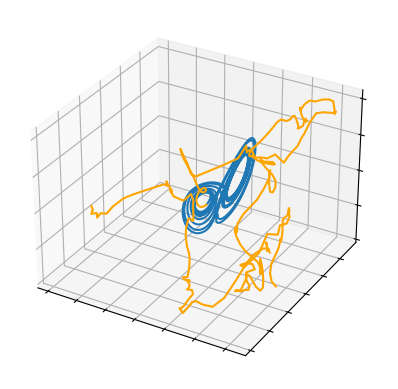

In [71]:
minter=1400
ax = plt.figure().add_subplot(projection='3d')
ax.plot(Xdum[0,:minter],Xdum[2,:minter] ,Xdum[4,:minter])
ax.plot(Xdum[0,minter:Xind3d[0]],Xdum[2,minter:Xind3d[0]] ,Xdum[4,minter:Xind3d[0]],color='orange')
rdum=0
for i in range(0,1):
    ax.plot(Xdum[0,(Xind3d[i]+1):(Xind3d[i+1]+1)],(Xdum[2,(Xind3d[i]+1):(Xind3d[i+1]+1)]), \
             Xdum[4,(Xind3d[i]+1):(Xind3d[i+1]+1)], color='orange')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10

#plt.savefig(f'Pictures_paper/unwinding_3d.jpg',dpi=1000,bbox_inches = 'tight')

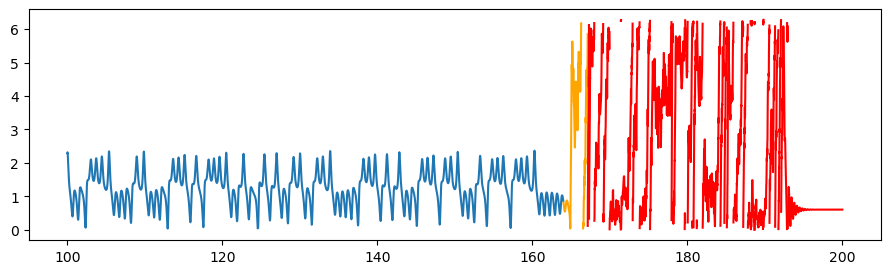

In [72]:
fig = plt.figure(figsize=(11,3))
X1test = (Xtest[0,:10_000] ) % np.pi*2
X1ind = np.where(np.abs(X1test[:-1] - X1test[1:])>1)[0]
minter=1400 + 5000
T= np.arange(0,20_000,1)/1_00 + 100
plt.plot(T[:X1ind[0]], X1test[:X1ind[0]])
plt.plot(T[X1ind[0]+5:minter],X1test[X1ind[0]+5:minter],c='#1f77b4')
plt.plot(T[minter+1:X1ind[2]+1],X1test[minter+1:X1ind[2]+1],c='orange')
for i in range(3,4):
    plt.plot(np.arange(X1ind[i],X1ind[i+1])/1_00 + 100, X1test[X1ind[i]+1:X1ind[i+1]+1], c='orange')
for i in range(4,X1ind.shape[0]-1):
    plt.plot(np.arange(X1ind[i],X1ind[i+1])/1_00 + 100, X1test[X1ind[i]+1:X1ind[i+1]+1], c='red')
plt.plot(np.arange(X1ind[i+1]+1,len(X1test))/1_00 + 100, X1test[X1ind[i+1]+1:], c='red')
    #ax.plot(Xdum[0,1450],Xdum[2,145],Xdum[4,1450],'.' )
plt.savefig(f'Pictures_paper/unwinding_1d.jpg',dpi=1000,bbox_inches = 'tight')
